In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
def option_value_3d(sigma, r, strike, expiration, lower_limit, upper_barrier, NAS, freq, payment):
    lower_limit = 3*lower_limit / 4
    dS = (upper_barrier - lower_limit) / NAS
    dt = 0.9 * dS**2 / sigma**2 / upper_barrier**2
    NTS = int(expiration / dt) + 1  # Number of time steps
    dt = expiration / NTS 

    V = np.zeros((NAS + 1, NTS + 1))  # Option value array
    S = np.arange(0, NAS + 1) * dS + lower_limit
    payoff_values = np.maximum(S - strike, 0)
    V[:, 0] = payoff_values

    freq_ = expiration / freq
    
    for k in range(1, NTS + 1):  # Time loop
        for i in range(1, NAS):  # Asset loop. End points treated separately
            delta = (V[i + 1, k - 1] - V[i - 1, k - 1]) / (2*dS)  # Central difference
            gamma = (V[i + 1, k - 1] - 2 * V[i, k - 1] + V[i - 1, k - 1]) / (2*dS) # Central difference
            theta = -0.5 * sigma ** 2 * S[i] ** 2 * gamma - r * S[i] * delta + r * V[i, k - 1]  # Black-Scholes
            V[i, k] = V[i, k - 1] - dt * theta
        
        V[0, k] = 2 * V[1,k] - V[2,k]
        V[NAS, k] = 0
        
        if (dt*(k+1) - freq_ > 0) :
            freq_ += freq_
            for i in range(NAS + 1):
                V[i, k] = np.maximum(V[i, k] - payment, 0)


    
    asset_range = np.arange(0, NAS + 1) * dS  # Asset price range
    time_steps = np.arange(0, NTS + 1) * dt
    rounded_time_steps = np.round(time_steps, decimals=3)
    df = pd.DataFrame(V, index=asset_range, columns=rounded_time_steps).round(3)

    return df  # Output array


In [4]:
sigma = 0.2
r = 0.05
K = 80
T = 1
NAS = 50 # number of asset steps
Lower_l = 5
up_barrier  = 120
frequency = 5
payment = 2

option_df = option_value_3d(sigma = sigma, r = r, strike = K,
                            expiration = T, lower_limit= Lower_l,
                            upper_barrier= up_barrier, NAS = NAS, 
                            freq=frequency, payment = payment)

In [6]:
def plot_heatmap(df):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, cmap='YlOrBr', fmt=".3f")
    plt.title('Option Values Heatmap')
    plt.xlabel('Time Steps')
    plt.ylabel('Asset Steps')
    plt.show()

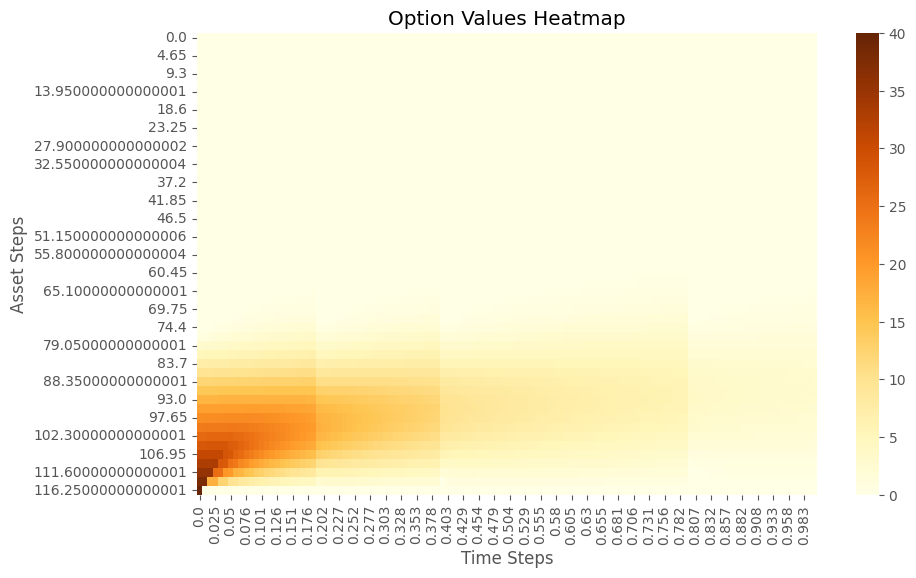

In [7]:
plot_heatmap(option_df)

In [21]:
def plot_3D(df, elevation, azim = None):
    fig = plt.figure(figsize=(8, 10))
    ax = fig.add_subplot(111, projection='3d')

    X, Y = np.meshgrid(df.columns, df.index)
    Z = df.values

    surf = ax.plot_surface(X, Y, Z, cmap='cividis')

    ax.set_xlabel('Time')
    ax.set_ylabel('Asset Price')
    ax.set_zlabel('Option Value')
    ax.set_title('Option Value Surface Plot')

    fig.colorbar(surf, shrink=0.5, aspect=55)
    ax.view_init(elev=elevation, azim=45) 
    if azim:
        ax.view_init(elev=elevation, azim=azim)

    plt.show()

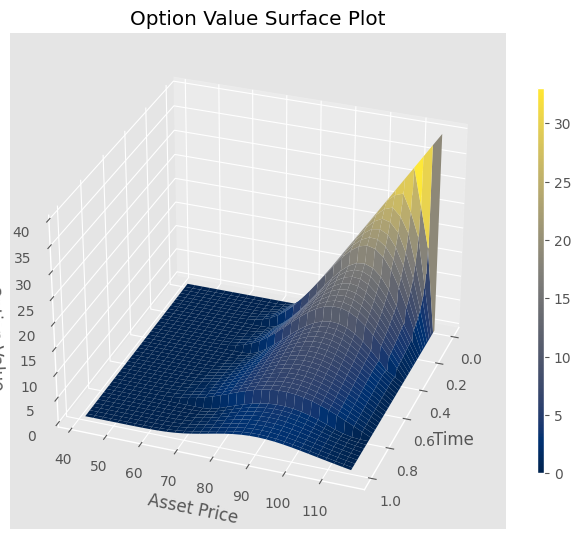

In [20]:
mask = option_df.index > 40
df_mask = option_df[mask]
plot_3D(df_mask, elevation= 30, azim = 20 )